In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager

In [2]:
section_chapters = {
    1 : range(1,6),
    2 : range(6,15),
    3 : range(15,16),
    4 : range(16,25),
    5 : range(25,28),
    6 : range(28,39),
    7 : range(39,41),
    8 : range(41,44),
    9 : range(44,47),
    10 : range(47,50),
    11 : range(50,64),
    12 : range(64,68),
    13 : range(68,71),
    14 : range(71,72),
    15 : range(72,84),
    16 : range(84,86),
    17 : range(86,90), 
    18 : range(90,93),
    19 : range(93,94),
    20 : range(94,97),
    21 : range(97,100)
}

section_names = {
    1 : 'Animal Products',
    2 : 'Vegetable Products',
    3 : 'Animal/Vegetable Fats',
    4 : 'Prepared Foodstuffs',
    5 : 'Mineral Products',
    6 : 'Chemical Products',
    7 : 'Plastics and Rubber',
    8 : 'Leather',
    9 : 'Wood',
    10 : 'Paper',
    11 : 'Textile',
    12 : 'Footwear',
    13 : 'Stone, Ceramic and Glass',
    14 : 'Jewelry',
    15 : 'Base Metals',
    16 : 'Machinery',
    17 : 'Vehicles, Aircrafts and Vessels',
    18 : 'Instruments and Apparatus',
    19 : 'Arms and Ammunition',
    20 : 'Miscellaneous',
    21 : 'Art'
}

In [3]:
def get_section_by_chapter(ch):
    for section in section_chapters:
        chapters = section_chapters[section]
        if ch in chapters:
            return section
    return -1

def preprocess():
    # Read dataset detailing exports for all Brazilian states.
    # File has around 1.5GB, so I'll ignore it in version control.
    # Download from http://www.mdic.gov.br/index.php/comercio-exterior/estatisticas-de-comercio-exterior/
    #               /base-de-dados-do-comercio-exterior-brasileiro-arquivos-para-download
    df = pd.read_csv(Path(r'C:\Users\erico\Documents\estudos\datasets\EXP_COMPLETA.csv'), sep=';')
    # Translating column names to English
    df.columns = ['Year',
                  'Month',
                  'HS Code',
                  'Statistical Unit Code',
                  'Country Code',
                  'State',
                  'Transport Code',
                  'URF Code',
                  'Statistical Quantity',
                  'Liquid Kilogram',
                  'FOB Value']
    # Filter only data from state of São Paulo
    sp = df[df['State']=='SP']
    # Save data to a file, so that we can read less data next time.
    sp.to_csv(Path(r'C:\Users\erico\Documents\estudos\datasets\EXP_SP.csv'))

    # Create a column which takes the 2 first digits from HS Code, which indicates Chapter in Harmonized System
    sp.loc[:,'Chapter'] = sp.loc[:,'HS Code'].astype(int).apply(lambda x : int(str('{:08d}'.format(x)[0:2])))

    # Groups by Year and Chapter and takes sum of all exports
    exp_chapter = sp.loc[:,['Year', 'Chapter', 'FOB Value']].groupby(['Year', 'Chapter']).sum()
    exp_chapter = exp_chapter.reset_index()
    
    # Saves this to a file
    exp_chapter.to_csv('Exports_By_Year_Chapter.csv')
    return exp_chapter

f = Path('Exports_By_Year_Chapter.csv', index_col=0)
if f.exists():
    exp_chapter = pd.read_csv(f)
else:
    exp_chapter = preprocess()

In [4]:
def filter_sections(exp_chapter):
    exp_chapter['Section'] = exp_chapter['Chapter'].apply(get_section_by_chapter)
    
    exp_section = exp_chapter.loc[:,['Year', 'Section', 'FOB Value']].groupby(['Year', 'Section']).sum()
    exp_section = exp_section.reset_index()
    exp_section['Section Name'] = exp_section['Section'].apply(lambda x : section_names[x])
    exp_section = exp_section[['Year','Section','Section Name','FOB Value']]
    exp_section = exp_section[exp_section['Year'] < 2020]
    
    exp_section.to_csv('Exports_By_Year_Section.csv')
    return exp_section

f = Path('Exports_By_Year_Section.csv')
if f.exists():
    exp_section = pd.read_csv(f, index_col=0)
else:
    exp_section = filter_sections(exp_chapter)

In [5]:
acc_exports = exp_section.set_index('Year').groupby('Section').sum()
aux = acc_exports.sort_values('FOB Value', ascending=False)[0:5]
top5 = list(aux.index)

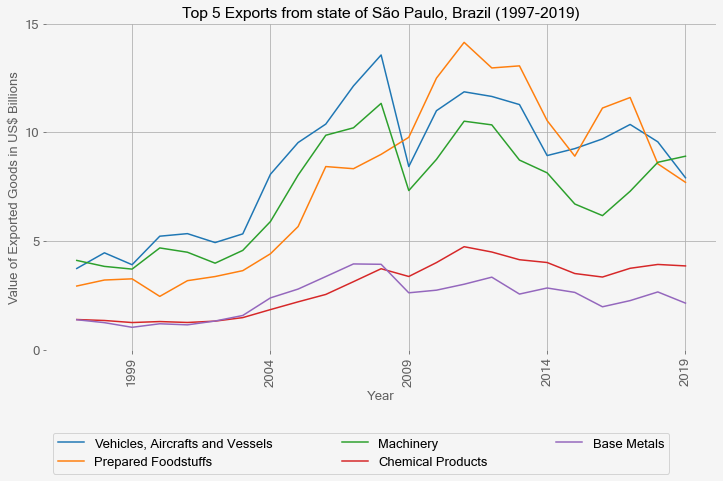

In [6]:
def plot_sections():
    series2plot = { d : exp_section[exp_section['Section']==d] for d in range(22) }

    cmap = cm.get_cmap(name='tab10')
    bgcolor = 'whitesmoke'
    tkcolor = '#606060'
    
    plt.figure(figsize=(12,6), facecolor=bgcolor)
    plt.rcParams['font.family'] = ['Microsoft Sans Serif', 'Arial', 'sans-serif']
    plt.rcParams['text.color'] = '#000000'
    plt.rcParams['axes.labelcolor']= tkcolor
    plt.rcParams['legend.facecolor']= bgcolor
    plt.rcParams['xtick.color'] = tkcolor
    plt.rcParams['ytick.color'] = tkcolor
    plt.rcParams['font.size']=13
    
    ax = plt.gca()
    ax.set_facecolor(bgcolor)
    
    years = [1999,2004,2009,2014,2019]
    vals = [0,5,10,15]
    
    i = 0
    for d in top5:
        df = series2plot[d]
        y = df['FOB Value'] / 10**9
        x = df['Year']
        plt.plot(x, y, label = section_names[d], color = cmap.colors[i])
        i += 1
    
    plt.ylabel('Value of Exported Goods in US$ Billions')
    plt.xlabel('Year')
    plt.xticks(years, rotation='vertical')
    plt.yticks(vals)
    plt.box(on=None)
    
    plt.grid()
    plt.legend(loc='lower left', mode='expand', ncol=3,bbox_to_anchor=(0,-0.4,0.94,1))
    plt.title('Top 5 Exports from state of São Paulo, Brazil (1997-2019)')

    plt.savefig('Assignment4.png')
    plt.show()    
    pass

plot_sections()